In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from __future__ import division

import numpy as np
import h5py
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import viz
import time
import copy
import data_utils

def fkl( angles, parent, offset, rotInd, expmapInd ):
  """
  Convert joint angles and bone lenghts into the 3d points of a person.
  Based on expmap2xyz.m, available at
  https://github.com/asheshjain399/RNNexp/blob/7fc5a53292dc0f232867beb66c3a9ef845d705cb/structural_rnn/CRFProblems/H3.6m/mhmublv/Motion/exp2xyz.m
  Args
    angles: 99-long vector with 3d position and 3d joint angles in expmap format
    parent: 32-long vector with parent-child relationships in the kinematic tree
    offset: 96-long vector with bone lenghts
    rotInd: 32-long list with indices into angles
    expmapInd: 32-long list with indices into expmap angles
  Returns
    xyz: 32x3 3d points that represent a person in 3d space
  """

  assert len(angles) == 99

  # Structure that indicates parents for each joint
  njoints   = 32
  xyzStruct = [dict() for x in range(njoints)]

  for i in np.arange( njoints ):

    if not rotInd[i] : # If the list is empty
      xangle, yangle, zangle = 0, 0, 0
    else:
      xangle = angles[ rotInd[i][0]-1 ]
      yangle = angles[ rotInd[i][1]-1 ]
      zangle = angles[ rotInd[i][2]-1 ]

    r = angles[ expmapInd[i] ]

    thisRotation = data_utils.expmap2rotmat(r)
    thisPosition = np.array([xangle, yangle, zangle])

    if parent[i] == -1: # Root node
      xyzStruct[i]['rotation'] = thisRotation
      xyzStruct[i]['xyz']      = np.reshape(offset[i,:], (1,3)) + thisPosition
    else:
      xyzStruct[i]['xyz'] = (offset[i,:] + thisPosition).dot( xyzStruct[ parent[i] ]['rotation'] ) + xyzStruct[ parent[i] ]['xyz']
      xyzStruct[i]['rotation'] = thisRotation.dot( xyzStruct[ parent[i] ]['rotation'] )

  xyz = [xyzStruct[i]['xyz'] for i in range(njoints)]
  xyz = np.array( xyz ).squeeze()
  xyz = xyz[:,[0,2,1]]
  # xyz = xyz[:,[2,0,1]]


  return np.reshape( xyz, [-1] )

def revert_coordinate_space(channels, R0, T0):
  """
  Bring a series of poses to a canonical form so they are facing the camera when they start.
  Adapted from
  https://github.com/asheshjain399/RNNexp/blob/7fc5a53292dc0f232867beb66c3a9ef845d705cb/structural_rnn/CRFProblems/H3.6m/dataParser/Utils/revertCoordinateSpace.m
  Args
    channels: n-by-99 matrix of poses
    R0: 3x3 rotation for the first frame
    T0: 1x3 position for the first frame
  Returns
    channels_rec: The passed poses, but the first has T0 and R0, and the
                  rest of the sequence is modified accordingly.
  """
  n, d = channels.shape

  channels_rec = copy.copy(channels)
  R_prev = R0
  T_prev = T0
  rootRotInd = np.arange(3,6)

  # Loop through the passed posses
  for ii in range(n):
    R_diff = data_utils.expmap2rotmat( channels[ii, rootRotInd] )
    R = R_diff.dot( R_prev )

    channels_rec[ii, rootRotInd] = data_utils.rotmat2expmap(R)
    T = T_prev + ((R_prev.T).dot( np.reshape(channels[ii,:3],[3,1]))).reshape(-1)
    channels_rec[ii,:3] = T
    T_prev = T
    R_prev = R

  return channels_rec

In [3]:
def _some_variables():
  """
  We define some variables that are useful to run the kinematic tree
  Args
    None
  Returns
    parent: 32-long vector with parent-child relationships in the kinematic tree
    offset: 96-long vector with bone lenghts
    rotInd: 32-long list with indices into angles
    expmapInd: 32-long list with indices into expmap angles
  """

  parent = np.array([0, 1, 2, 3, 4, 5, 1, 7, 8, 9,10, 1,12,13,14,15,13,
                    17,18,19,20,21,20,23,13,25,26,27,28,29,28,31])-1
    
  offset = np.array([0.000000,0.000000,0.000000,-132.948591,0.000000,0.000000,0.000000,-442.894612,0.000000,0.000000,-454.206447,0.000000,0.000000,0.000000,162.767078,0.000000,0.000000,74.999437,132.948826,0.000000,0.000000,0.000000,-442.894413,0.000000,0.000000,-454.206590,0.000000,0.000000,0.000000,162.767426,0.000000,0.000000,74.999948,0.000000,0.100000,0.000000,0.000000,233.383263,0.000000,0.000000,257.077681,0.000000,0.000000,121.134938,0.000000,0.000000,115.002227,0.000000,0.000000,257.077681,0.000000,0.000000,151.034226,0.000000,0.000000,278.882773,0.000000,0.000000,251.733451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99.999627,0.000000,100.000188,0.000000,0.000000,0.000000,0.000000,0.000000,257.077681,0.000000,0.000000,151.031437,0.000000,0.000000,278.892924,0.000000,0.000000,251.728680,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99.999888,0.000000,137.499922,0.000000,0.000000,0.000000,0.000000])
  offset = offset.reshape(-1,3)

  rotInd = [[5, 6, 4],
            [8, 9, 7],
            [11, 12, 10],
            [14, 15, 13],
            [17, 18, 16],
            [],
            [20, 21, 19],
            [23, 24, 22],
            [26, 27, 25],
            [29, 30, 28],
            [],
            [32, 33, 31],
            [35, 36, 34],
            [38, 39, 37],
            [41, 42, 40],
            [],
            [44, 45, 43],
            [47, 48, 46],
            [50, 51, 49],
            [53, 54, 52],
            [56, 57, 55],
            [],
            [59, 60, 58],
            [],
            [62, 63, 61],
            [65, 66, 64],
            [68, 69, 67],
            [71, 72, 70],
            [74, 75, 73],
            [],
            [77, 78, 76],
            []]

  expmapInd = np.split(np.arange(4,100)-1,32)

  return parent, offset, rotInd, expmapInd

In [11]:
np.split(np.arange(4,100)-1,32)

AttributeError: 'list' object has no attribute 'shape'

<IPython.core.display.Javascript object>


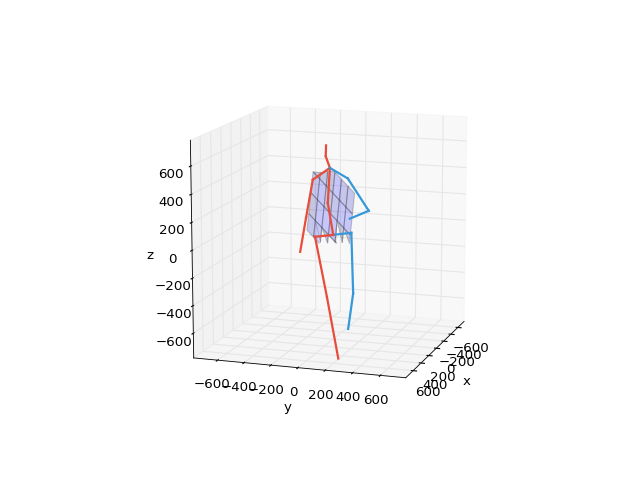

In [4]:
#### def main():

# Load all the data
parent, offset, rotInd, expmapInd = _some_variables()

# numpy translation implementation
with h5py.File( 'samples.h5', 'r' ) as h5f:
    expmap_gt = h5f['expmap/gt/walking_0'][:]
    expmap_pred = h5f['expmap/preds/walking_0'][:]

nframes_gt, nframes_pred = expmap_gt.shape[0], expmap_pred.shape[0]

# Put them together and revert the coordinate space
expmap_all = revert_coordinate_space( np.vstack((expmap_gt, expmap_pred)), np.eye(3), np.zeros(3) )
expmap_gt   = expmap_all[:nframes_gt,:]
expmap_pred = expmap_all[nframes_gt:,:]

# Compute 3d points for each frame
xyz_gt, xyz_pred = np.zeros((nframes_gt, 96)), np.zeros((nframes_pred, 96))
for i in range( nframes_gt ):
    xyz_gt[i,:] = fkl( expmap_gt[i,:], parent, offset, rotInd, expmapInd )
for i in range( nframes_pred ):
    xyz_pred[i,:] = fkl( expmap_pred[i,:], parent, offset, rotInd, expmapInd )

# Plot pose
fig = plt.figure()
ax = plt.gca(projection='3d')
ob = viz.Ax3DPose(ax)

In [6]:
# Plot the conditioning ground truth
for i in range(nframes_gt):
#     print i
    ob.update( xyz_gt[i,:] )
    plt.show(block=True)
    fig.canvas.draw()
#     plt.pause(0.01)

viz.py:78: RuntimeWarning: invalid value encountered in less
  Z[Z<zLL] = np.NaN


<IPython.core.display.Javascript object>


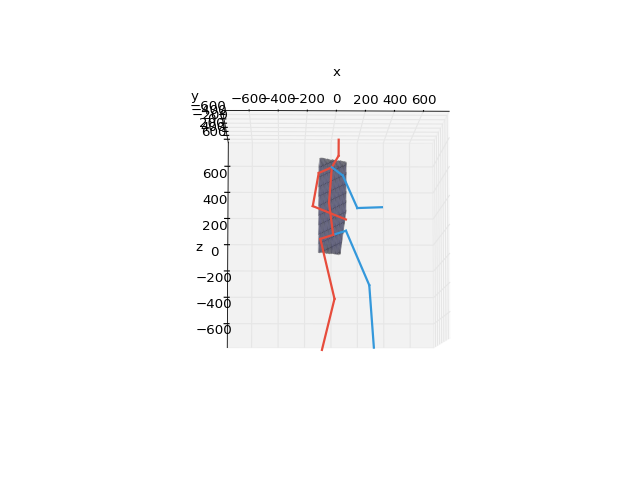

viz.py:78: RuntimeWarning: invalid value encountered in less
  Z[Z<zLL] = np.NaN


In [8]:
fig = plt.figure()
ax = plt.gca(projection='3d')
ob = viz.Ax3DPose(ax)
for i in range(nframes_pred):
#     print i
    ob.update( xyz_pred[i,:] )
#     del ax.lines[0]
    fig.canvas.draw()
    plt.show(block=False)
#     plt.pause(0.01)